C:\Users\timkf\AppData\Local\Temp\ipykernel_17252\3077392518.py:42: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  funding = pd.read_csv("D:\\Homework\\QF634\\project\\TAOUSDT_funding_rate_20200101_20251130.csv", parse_dates=["fundingDateTime"], date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S.%f"))


Rows: 3585 Columns: 28
Index(['funding_rate', 'markPrice', 'spot_open', 'spot_high', 'spot_low',
       'spot_close', 'spot_volume', 'spot_close_time',
       'spot_quote_asset_volume', 'spot_number_of_trades',
       'spot_taker_buy_base_asset_volume', 'spot_taker_buy_quote_asset_volume',
       'spot_ignore', 'spot_datetime', 'spot_index_interval', 'fut_open',
       'fut_high', 'fut_low', 'fut_close', 'fut_volume', 'fut_close_time',
       'fut_quote_asset_volume', 'fut_number_of_trades',
       'fut_taker_buy_base_asset_volume', 'fut_taker_buy_quote_asset_volume',
       'fut_ignore', 'fut_datetime', 'fut_index_interval'],
      dtype='object')


C:\Users\timkf\AppData\Local\Temp\ipykernel_17252\3077392518.py:65: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return series.pct_change(periods)
C:\Users\timkf\AppData\Local\Temp\ipykernel_17252\3077392518.py:68: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["spot_vol_24"] = df["spot_close"].pct_change().rolling(24).std()
C:\Users\timkf\AppData\Local\Temp\ipykernel_17252\3077392518.py:65: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fi

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	training's rmse: 6.24019e-05	valid_1's rmse: 3.64589e-05
Epoch 1/50
45/45 - 2s - 55ms/step - loss: 0.4289 - val_loss: 0.1624 - learning_rate: 1.0000e-03
Epoch 2/50
45/45 - 1s - 21ms/step - loss: 0.4086 - val_loss: 0.1608 - learning_rate: 1.0000e-03
Epoch 3/50
45/45 - 1s - 21ms/step - loss: 0.4067 - val_loss: 0.1601 - learning_rate: 1.0000e-03
Epoch 4/50
45/45 - 1s - 22ms/step - loss: 0.4029 - val_loss: 0.1608 - learning_rate: 1.0000e-03
Epoch 5/50
45/45 - 1s - 21ms/step - loss: 0.4012 - val_loss: 0.1600 - learning_rate: 1.0000e-03
Epoch 6/50
45/45 - 1s - 21ms/step - loss: 0.3989 - val_loss: 0.1606 - learning_rate: 1.0000e-03
Epoch 7/50
45/45 - 1s - 20ms/step - loss: 0.3947 - val_loss: 0.1615 - learning_rate: 1.0000e-03
Epoch 8/50
45/45 - 1s - 21ms/step - loss: 0.3911 - val_loss: 0.1621 - learning_rate: 1.0000e-03
Epoch 9/50
45/45 - 1s - 22ms/step - loss: 0.3906 - val_loss: 0.1611 - lear

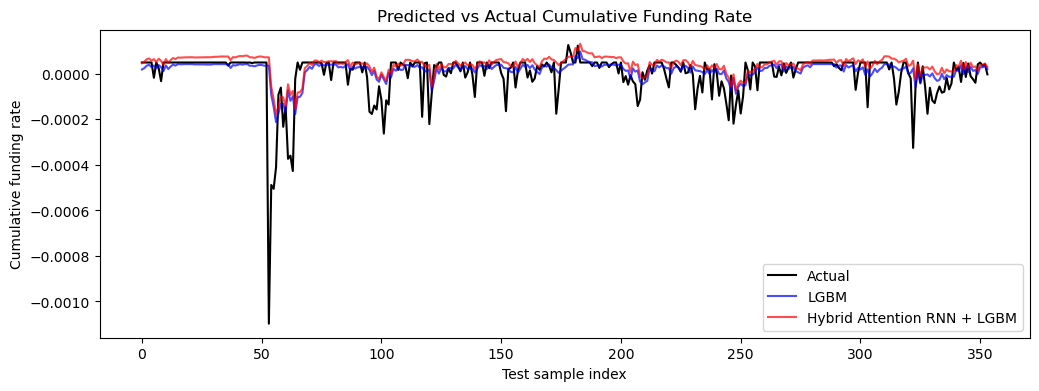

Models and scalers saved.


In [4]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Multiply, Permute, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# ----------------------------
# CONFIG
WINDOW = 48               # number of past timesteps for RNN
FUTURE_PERIODS = 1        # target = sum of next 6 funding rates
TEST_RATIO = 0.1
VAL_RATIO = 0.1           # fraction of train to hold-out for stacking
BATCH_SIZE = 64
EPOCHS = 50

# ----------------------------
# 1) LOAD DATA
# Expect a DataFrame `df` with:
# timestamp (datetime), columns for spot: spot_open, spot_high, spot_low, spot_close, spot_volume, ...
# and future: fut_open, fut_close, ..., and funding_rate column (per period)
# Adjust column names if different.
#
# Example: df = pd.read_csv("merged_spot_future.csv", parse_dates=["timestamp"])
# For this pipeline I'll assume df already merged with prefix 'spot_' and 'fut_',
# and funding rate column 'funding_rate' (which is the rate at that timestamp)
# ----------------------------
funding = pd.read_csv("D:\\Homework\\QF634\\project\\TAOUSDT_funding_rate_20200101_20251130.csv", parse_dates=["fundingDateTime"], date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S.%f"))
funding = funding.sort_values("fundingDateTime").drop("formattedFundingDateTime",axis = 1).drop("symbol",axis = 1)
funding.rename(columns={'fundingDateTime': 'timestamp','fundingRate':"funding_rate"}, inplace=True)
spot = pd.read_json('D:\\Homework\\QF634\\project\\Data\\raw_historical_price\\TAOUSDT_5m_binance_spot_historical_data.json',lines=True)           # columns: timestamp, open, high, low, close, volume, quote_asset_volume, number_of_trades, taker_buy_base_asset_volume, taker_buy_quote_asset_volume
future = pd.read_json('D:\\Homework\\QF634\\project\\Data\\raw_historical_price\\TAOUSDT_5m_binance_futures_historical_data.json',lines=True) 
funding.set_index('timestamp', inplace=True)
spot.set_index('timestamp', inplace=True)
future.set_index('timestamp', inplace=True)
df_future_renamed = future.add_prefix("fut_")
df_spot_renamed = spot.add_prefix("spot_")
# Important: rename the key column back so merge works
df_future_renamed = df_future_renamed.rename(columns={"fut_timestamp": "timestamp"})
df_spot_renamed = df_spot_renamed.rename(columns={"spot_timestamp": "timestamp"})

df = funding.merge(df_spot_renamed, left_index=True, right_index=True, how='left').merge(df_future_renamed, left_index=True, right_index=True, how='left', )

# quick sanity
print("Rows:", len(df), "Columns:", df.shape[1])
print(df.columns)
# ----------------------------
# 2) FEATURE ENGINEERING (per-timestep)
# ----------------------------
def pct_change(series, periods=1):
    return series.pct_change(periods)

df["spot_ret_1"] = pct_change(df["spot_close"], 1)
df["spot_vol_24"] = df["spot_close"].pct_change().rolling(24).std()
df["fut_ret_1"] = pct_change(df["fut_close"], 1)
df["fut_vol_24"] = df["fut_close"].pct_change().rolling(24).std()
df["spread_close"] = df["fut_close"] - df["spot_close"]
df["spread_ret_1"] = df["spread_close"].pct_change()
df["funding_delta_1"] = df["funding_rate"].diff(1)
df["funding_slope_6"] = df["funding_rate"].rolling(6).apply(lambda x: np.polyfit(np.arange(6), x, 1)[0])
df["funding_mean_6"] = df["funding_rate"].rolling(6).mean()

df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)

# ----------------------------
# 3) MULTI-STEP TARGET
y_multi = np.array([
    df["funding_rate"].iloc[i+WINDOW:i+WINDOW+FUTURE_PERIODS].values
    for i in range(len(df) - WINDOW - FUTURE_PERIODS + 1)
])

# ----------------------------
# 4) SEQUENCE & TABULAR FEATURES
feature_cols = [
    "spot_close","spot_ret_1","spot_vol_24",
    "fut_close","fut_ret_1","fut_vol_24",
    "spread_close","spread_ret_1",
    "funding_delta_1","funding_slope_6","funding_mean_6"
]

seq_X = []
tab_X = []
for start in range(len(df) - WINDOW - FUTURE_PERIODS + 1):
    end = start + WINDOW
    seq_X.append(df.iloc[start:end][feature_cols].values)  # <-- iloc
    tab_X.append(df.iloc[end-1][feature_cols].values)      # <-- iloc

seq_X = np.array(seq_X)
tab_X = np.array(tab_X)

# ----------------------------
# 5) TRAIN/VAL/TEST SPLIT
n_samples = seq_X.shape[0]
train_idx = np.arange(0, int(n_samples*0.8))
val_idx = np.arange(int(n_samples*0.8), int(n_samples*0.9))
test_idx = np.arange(int(n_samples*0.9), n_samples)

X_seq_train, X_seq_val, X_seq_test = seq_X[train_idx], seq_X[val_idx], seq_X[test_idx]
X_tab_train, X_tab_val, X_tab_test = tab_X[train_idx], tab_X[val_idx], tab_X[test_idx]
y_train_multi, y_val_multi, y_test_multi = y_multi[train_idx], y_multi[val_idx], y_multi[test_idx]

# ----------------------------
# 6) SCALE FEATURES
tab_scaler = StandardScaler()
X_tab_train_scaled = tab_scaler.fit_transform(X_tab_train)
X_tab_val_scaled = tab_scaler.transform(X_tab_val)
X_tab_test_scaled = tab_scaler.transform(X_tab_test)

n_feat = X_seq_train.shape[2]
seq_flat = X_seq_train.reshape(-1, n_feat)
seq_scaler = StandardScaler().fit(seq_flat)
def scale_sequences(seqs, scaler):
    n_samples = seqs.shape[0]
    s = seqs.reshape(-1, seqs.shape[2])
    s = scaler.transform(s)
    return s.reshape(n_samples, WINDOW, s.shape[1])

X_seq_train_scaled = scale_sequences(X_seq_train, seq_scaler)
X_seq_val_scaled = scale_sequences(X_seq_val, seq_scaler)
X_seq_test_scaled = scale_sequences(X_seq_test, seq_scaler)

y_scaler = StandardScaler().fit(y_train_multi)
y_train_scaled = y_scaler.transform(y_train_multi)
y_val_scaled = y_scaler.transform(y_val_multi)

# ----------------------------
# 7) TRAIN LIGHTGBM
y_train_sum = y_train_multi.sum(axis=1)
y_val_sum = y_val_multi.sum(axis=1)
y_test_sum = y_test_multi.sum(axis=1)

lgb_train = lgb.Dataset(X_tab_train_scaled, label=y_train_sum)
lgb_val = lgb.Dataset(X_tab_val_scaled, label=y_val_sum, reference=lgb_train)

lgb_params = {
    "objective":"regression","metric":"rmse","verbosity":-1,
    "learning_rate":0.05,"num_leaves":64,"seed":SEED
}

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

pred_lgb_train = lgb_model.predict(X_tab_train_scaled)
pred_lgb_val = lgb_model.predict(X_tab_val_scaled)
pred_lgb_test = lgb_model.predict(X_tab_test_scaled)

# ----------------------------
# 8) RNN residual target
lgb_train_step = np.tile(pred_lgb_train.reshape(-1,1)/FUTURE_PERIODS,(1,FUTURE_PERIODS))
lgb_val_step = np.tile(pred_lgb_val.reshape(-1,1)/FUTURE_PERIODS,(1,FUTURE_PERIODS))

y_train_residual_scaled = y_train_scaled - y_scaler.transform(lgb_train_step)
y_val_residual_scaled = y_val_scaled - y_scaler.transform(lgb_val_step)

# ----------------------------
# 9) LSTM WITH ATTENTION
tf.keras.backend.clear_session()
inputs = Input(shape=(WINDOW,n_feat))
lstm_out = LSTM(128, return_sequences=True)(inputs)
# attention mechanism
attention = Dense(1, activation='tanh')(lstm_out)
attention = tf.keras.layers.Flatten()(attention)
attention_weights = tf.keras.layers.Activation('softmax')(attention)
attention_weights = tf.keras.layers.RepeatVector(128)(attention_weights)
attention_weights = Permute([2,1])(attention_weights)
context_vector = Multiply()([lstm_out, attention_weights])
context_vector = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(context_vector)
dense1 = Dense(64, activation='relu')(context_vector)
dense1 = Dropout(0.2)(dense1)
outputs = Dense(FUTURE_PERIODS)(dense1)

rnn_model = Model(inputs, outputs)
rnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)
]

history = rnn_model.fit(
    X_seq_train_scaled, y_train_residual_scaled,
    validation_data=(X_seq_val_scaled, y_val_residual_scaled),
    epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=2
)

# ----------------------------
# 10) HYBRID PREDICTION
def hybrid_predict(rnn_model, X_seq, lgb_pred_sum):
    pred_res_scaled = rnn_model.predict(X_seq)
    pred_res = y_scaler.inverse_transform(pred_res_scaled)
    return lgb_pred_sum + pred_res.sum(axis=1)

pred_test_hybrid = hybrid_predict(rnn_model, X_seq_test_scaled, pred_lgb_test)

# ----------------------------
# 11) EVALUATION
def print_metrics(true, pred, tag=""):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    print(f"{tag} RMSE: {rmse:.6f}, MAE: {mae:.6f}")

print_metrics(y_test_sum, pred_lgb_test, "LGBM")
print_metrics(y_test_sum, pred_test_hybrid, "Hybrid Attention RNN + LGBM")

# ----------------------------
# 12) PLOT PREDICTIONS
plt.figure(figsize=(12,4))
plt.plot(y_test_sum, label='Actual', color='black')
plt.plot(pred_lgb_test, label='LGBM', color='blue', alpha=0.7)
plt.plot(pred_test_hybrid, label='Hybrid Attention RNN + LGBM', color='red', alpha=0.7)
plt.title("Predicted vs Actual Cumulative Funding Rate")
plt.xlabel("Test sample index")
plt.ylabel("Cumulative funding rate")
plt.legend()
plt.show()

# ----------------------------
# 13) SAVE MODELS
lgb_model.save_model("lgb_model.txt")
rnn_model.save("rnn_attention_model.h5")
import joblib
joblib.dump(tab_scaler,"tab_scaler.pkl")
joblib.dump(seq_scaler,"seq_scaler.pkl")
joblib.dump(y_scaler,"y_scaler.pkl")

print("Models and scalers saved.")
